In [1]:
# qmc module, ensure scipy correct version before anything

import scipy

import os
import numpy as np
import cv2

import tensorflow as tf
import subprocess
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import tensorflow_probability as tfp

import xplique
from xplique.attributions import *
from xplique.metrics import *

from xplique_addons import *
from utils import *

red_tr    = get_alpha_cmap('Reds')

# HSIC attribution method

Here you can run the code to produce explanations for the provided input images, extracted from ImageNet.

## Model & Images

In [2]:
batch_size = 256

images_classes = [
                  ('assets/fox.png', 278),
                  ('assets/leopard.png', 288),
                  ('assets/polar_bear.png', 296),
                  ('assets/snow_fox.png', 279),
]

X_raw = np.array([load_image(p) for p, y in images_classes])
Y_true = np.array([y for p, y in images_classes])


model = tf.keras.applications.ResNet50V2()
model.layers[-1].activation = tf.keras.activations.linear
inputs =  tf.keras.applications.resnet_v2.preprocess_input(np.array([x.copy() for x in X_raw], copy=True))

labels = np.argmax(model.predict(inputs, batch_size=batch_size), axis=-1)
labels_ohe = tf.one_hot(labels, 1000)

## Explanations

You can play with `grid_size` and `nb_forward` parameters.

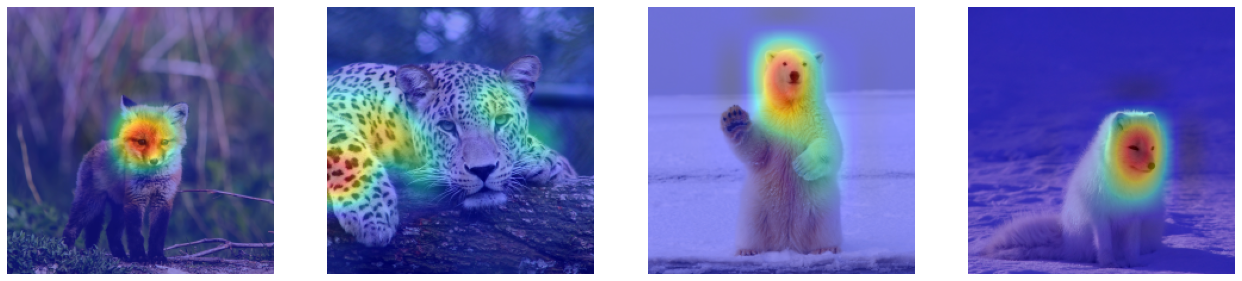

In [3]:
grid_size = 7
nb_forward = 1536


hsic_explainer = HsicAttributionMethod(model, 
                                      grid_size = grid_size, 
                                      nb_design = nb_forward , 
                                      sampler = HsicLHSSampler(binary=True), 
                                      estimator = HsicEstimator(kernel_type="binary"),
                                      perturbation_function = 'inpainting',
                                      batch_size = 256)

explanations = hsic_explainer(inputs, labels_ohe)
explanations = np.array(explanations)

set_size(22, 12)
for i in range(4):
    plt.subplot(1, 4, i+1)
    show(inputs[i])
    show(explanations[i], cmap="jet", alpha=0.4)
plt.show()

    


# Interactions

Here you can run the code to obtain interaction plots. Note that you have to specify the index of the patch of which you want to assess the interactions (`base_inter`). Finding relevant interactions require investigation efforts since we have to assess all the explanations for all the patch pairs. Not all of them interact, and not all of the images exhibit interaction phenomenon. Therefore, we already cherrypicked:

* Images with relevant interactions
* Indices of patches that most interact with other patches.

Indices are found in the dictionnary `cherrypick`.

## Model & Images

In [10]:

img_paths = [
    "assets/ILSVRC2012_val_00000001.JPEG",
    "assets/ILSVRC2012_val_00000002.JPEG",
    "assets/ILSVRC2012_val_00000012.JPEG",
    "assets/ILSVRC2012_val_00000030.JPEG"
]


X_raw = np.array([load_image(p) for p in img_paths])
inputs =  tf.keras.applications.resnet_v2.preprocess_input(np.array([x.copy() for x in X_raw], copy=True))
labels = np.argmax(model.predict(inputs, batch_size=batch_size), axis=-1)
labels_ohe = tf.one_hot(labels, 1000)

cherrypick = {
        0: 13, #Actual ImegeNet index: 1
        1: 6, #Actual ImegeNet index: 2
    2:24, #Actual ImegeNet index: 12
    3: 13 #Actual ImegeNet index: 30
}

## Explanations

You can play with `grid_size` and `nb_forward` parameters.

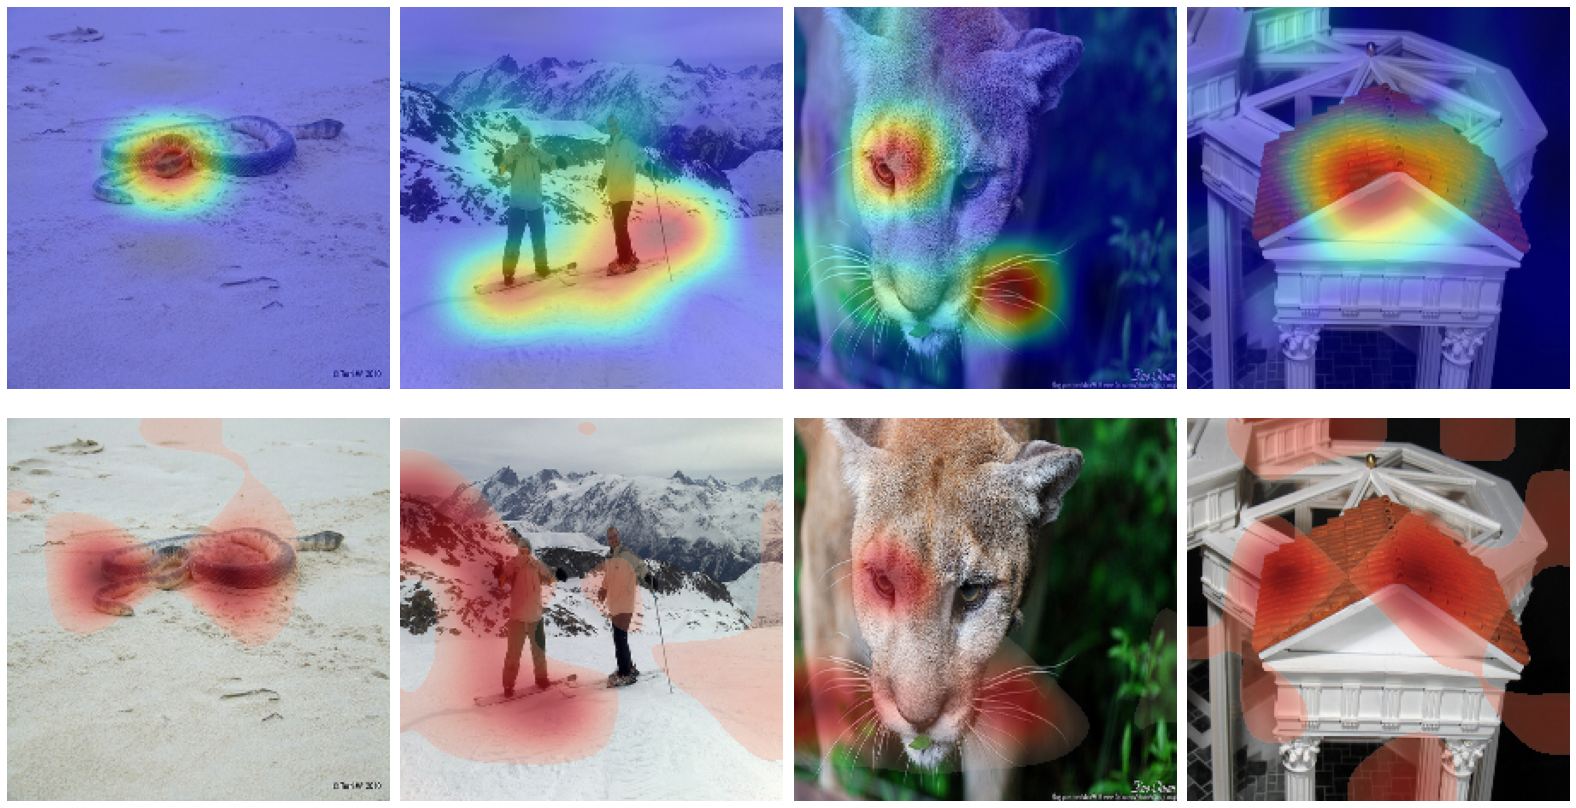

In [11]:
grid_size = 6
nb_forward  = 1024

set_size(22, 12)
perc = [20, 40, 40, 40]
for k, im in enumerate(cherrypick.keys()):
    
    hsic_explainer = HsicAttributionMethod(model, 
                                          grid_size = grid_size, 
                                          nb_design = nb_forward, 
                                          sampler = HsicSampler(binary=True), 
                                          estimator = HsicEstimator(kernel_type="inter", base_inter=cherrypick[im]),
                                          perturbation_function = 'inpainting',
                                          batch_size = 256)

    explanations_inter =  hsic_explainer(inputs[im:im+1], labels_ohe[im:im+1])
    
    hsic_explainer = HsicAttributionMethod(model, 
                                      grid_size = grid_size, 
                                      nb_design = nb_forward , 
                                      sampler = HsicSampler(binary=True), 
                                      estimator = HsicEstimator(kernel_type="binary"),
                                      perturbation_function = 'inpainting',
                                      batch_size = 256)

    explanations_uni = hsic_explainer(inputs[im:im+1], labels_ohe[im:im+1])

    plt.subplot(2, 4, k +1)
    show(inputs[im])
    
    percentile = perc[k]
    heatmap = np.array(explanations_uni)
    show(heatmap, cmap="jet", alpha=0.4)
    if k == 0:
        plt.ylabel(r"\mathcal{S}_i")
    plt.subplot(2, 4, k + 5)
    
    show(inputs[im])
    heatmap = np.array(explanations_inter)
    t = np.percentile(heatmap.flatten(), 100 - percentile)
    heatmap = 0.0 + (heatmap > t) * heatmap
    show(heatmap, cmap=red_tr, alpha=0.7)
    if k == 0:
        plt.ylabel(r"\mathcal{S}_{i \times j")
        
plt.tight_layout()
plt.show()
    